<a href="https://colab.research.google.com/github/BRIAN12682/Automation-Projects/blob/main/ArchitecturesftGRADCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Validation, training and test sets

In [2]:
!pip install tensorflow

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

dataset_folder = '/content/drive/MyDrive/Resized_Annotated_Folder'

def parse_xml_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    label = 0
    coordinates_list = []

    for object_element in root.findall('object'):
        bndbox = object_element.find('bndbox')

        if bndbox is not None:
            label = 1
            x = int(float(bndbox.find('xmin').text))
            y = int(float(bndbox.find('ymin').text))
            width = int(float(bndbox.find('xmax').text) - x)
            height = int(float(bndbox.find('ymax').text) - y)

            coordinates_list.append((x, y, width, height))

    return label, coordinates_list

images = []
annotations = []

for root_folder in os.listdir(dataset_folder):
    root_folder_path = os.path.join(dataset_folder, root_folder)

    if os.path.isdir(root_folder_path):
        label = 1 if root_folder == 'With_Bounding_Boxes' else 0

        for filename in os.listdir(root_folder_path):
            if filename.endswith('.jpg'):
                # Load image
                image_path = os.path.join(root_folder_path, filename)
                img = cv2.imread(image_path)
                images.append(img)

                 # Load corresponding XML annotation
                xml_filename = os.path.splitext(filename)[0] + '.xml'
                xml_path = os.path.join(dataset_folder, 'annotation', xml_filename)
                label, annotation = parse_xml_annotation(xml_path)
                annotations.append(label)

X = np.array(images)
y = np.array(annotations)


y_int = y.astype(int)

if np.sum(y_int == 0) == 0 or np.sum(y_int == 1) == 0:
    raise ValueError("Error: There are no samples for one or both classes. Check your data.")

# Counting the number of samples in each class
class_counts = np.bincount(y_int)

# Print class counts for debugging
print("Class Counts:", class_counts)
min_class_count = np.min(class_counts[class_counts > 0])
print("Minimum Class Count:", min_class_count)

test_size = int(min_class_count * 0.2)
train_size = min_class_count - test_size

indices_train, indices_val, y_train, y_val = train_test_split(
    np.arange(len(X)),
    y_int,
    test_size=test_size,
    train_size=train_size,
    stratify=y_int,
    random_state=42
)

X_train, X_val = X[indices_train], X[indices_val]



# SAVING THE SETS

In [8]:

save_path = '/content/drive/MyDrive/Resized_Annotated_Folder/'

# Save images and annotations
np.save(os.path.join(save_path, 'X.npy'), X)
np.save(os.path.join(save_path, 'y.npy'), y)

# Save train-test split indices
np.save(os.path.join(save_path, 'indices_train.npy'), indices_train)
np.save(os.path.join(save_path, 'indices_val.npy'), indices_val)

NameError: name 'X' is not defined

# LOADING THE SETS

In [5]:
from tensorflow.keras.models import save_model
import numpy as np
import os
load_path = '/content/drive/MyDrive/Resized_Annotated_Folder/'

# Load images and annotations
X = np.load(os.path.join(load_path, 'X.npy'))
y = np.load(os.path.join(load_path, 'y.npy'))

# Load train-test split indices
indices_train = np.load(os.path.join(load_path, 'indices_train.npy'))
indices_val = np.load(os.path.join(load_path, 'indices_val.npy'))


# MOBILE NET

In [6]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten

def create_mobilenet_branch(input_shape=(224, 224, 3), save_path='mobilenet_branch_model.h5'):
    mobilenet_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')
    for layer in mobilenet_model.layers:
        layer.trainable = True

    model = Sequential()
    model.add(mobilenet_model)
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.save(save_path)

    return model
mobilenet_branch_save_path = '/content/drive/MyDrive/Resized_Annotated_Folder/mobilenet_branch_model.h5'
mobilenet_branch = create_mobilenet_branch(save_path=mobilenet_branch_save_path)

mobilenet_branch.summary()


17225924/17225924 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3360193 (12.82 MB)
Trainable params: 3338305 (12.73 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


In [ ]:
!pip install tensorflow

In [7]:
# Assuming you've already loaded your datasets (cnn_branch_X_train, cnn_branch_y_train, cnn_branch_X_val, cnn_branch_y_val)
from tensorflow.keras.models import load_model

# MobileNet Branch
mobilenet_branch_X_train = X_train
mobilenet_branch_y_train = y_train
mobilenet_branch_X_val = X_val
mobilenet_branch_y_val = y_val


mobilenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/mobilenet_branch_model.h5'
mobilenet_model = load_model(mobilenet_model_path)

# Compile the MobileNet model
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the MobileNet model
mobilenet_model.fit(mobilenet_branch_X_train, mobilenet_branch_y_train, validation_data=(mobilenet_branch_X_val, mobilenet_branch_y_val), epochs=10, batch_size=32)


NameError: name 'X_train' is not defined

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

mobilenet_predictions = mobilenet_model.predict(mobilenet_branch_X_val)
mobilenet_predictions = (mobilenet_predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(mobilenet_branch_y_val, mobilenet_predictions)
classification_report_output = classification_report(mobilenet_branch_y_val, mobilenet_predictions, target_names=['Class 0', 'Class 1'])

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_output)


2/2 [==============================] - 5s 2s/step
Accuracy: 0.9286
Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.33      0.50         6
     Class 1       0.93      1.00      0.96        50

    accuracy                           0.93        56
   macro avg       0.96      0.67      0.73        56
weighted avg       0.93      0.93      0.91        56



2/2 [==============================] - 6s 3s/step


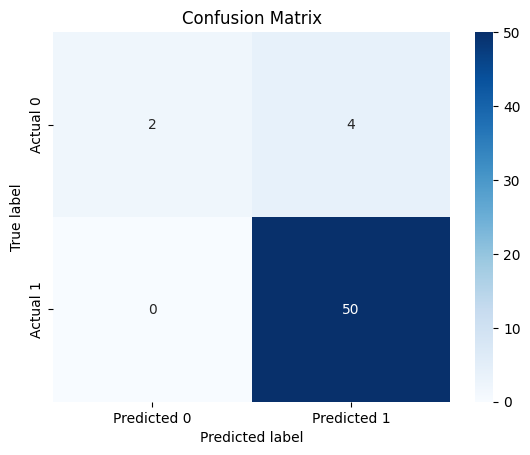

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you've already loaded your datasets (mobilenet_branch_X_val, mobilenet_branch_y_val)

# Evaluate the MobileNet model on the validation set
mobilenet_predictions = mobilenet_model.predict(mobilenet_branch_X_val)
mobilenet_predictions = (mobilenet_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate the confusion matrix
conf_matrix = confusion_matrix(mobilenet_branch_y_val, mobilenet_predictions)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

mobilenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/mobilenet_branch_model.h5'
mobilenet_model = load_model(mobilenet_model_path)

mobilenet_model.summary()

last_layer_name = mobilenet_model.layers[-1].name
print("Last Layer Name:", last_layer_name)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3360193 (12.82 MB)
Trainable params: 131329 (513.00 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________
Last Layer 

In [ ]:
!pip install tensorflow

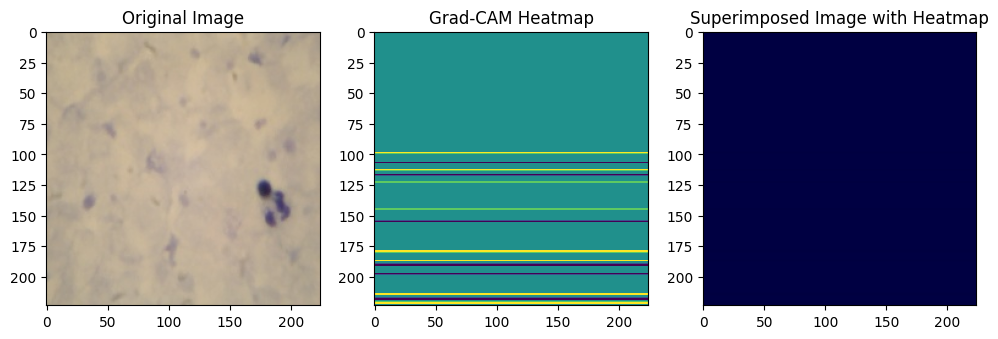

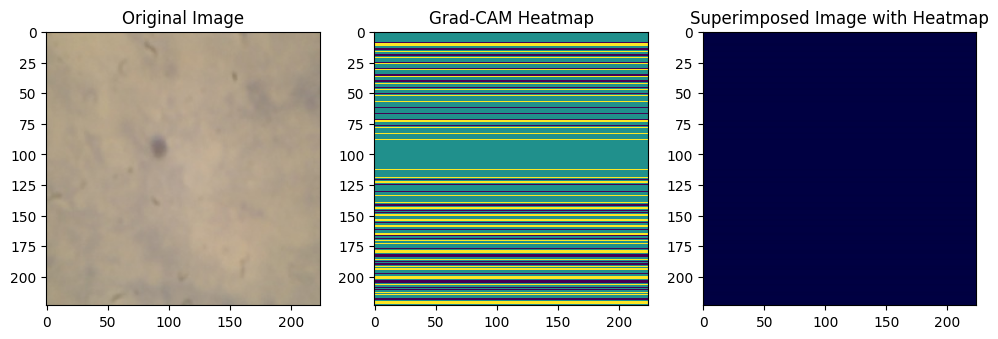

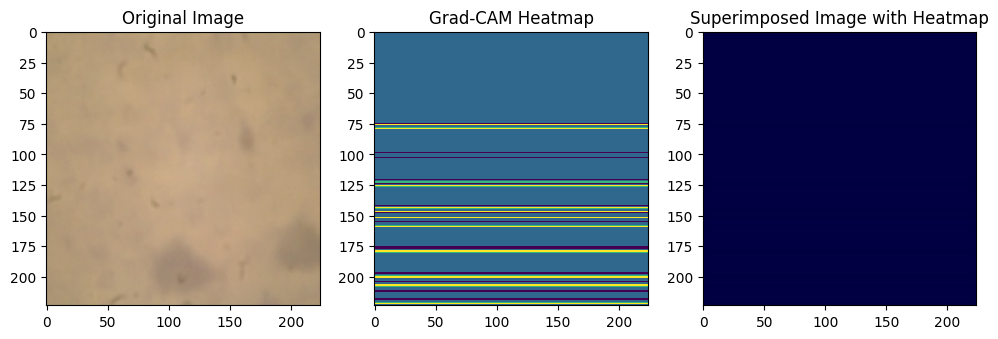

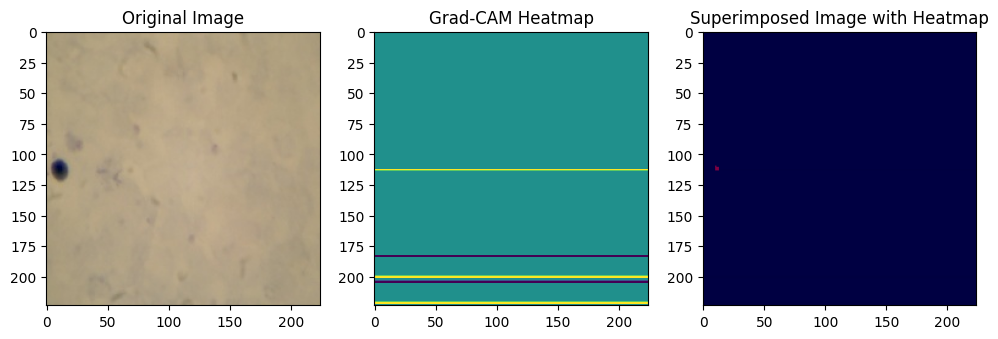

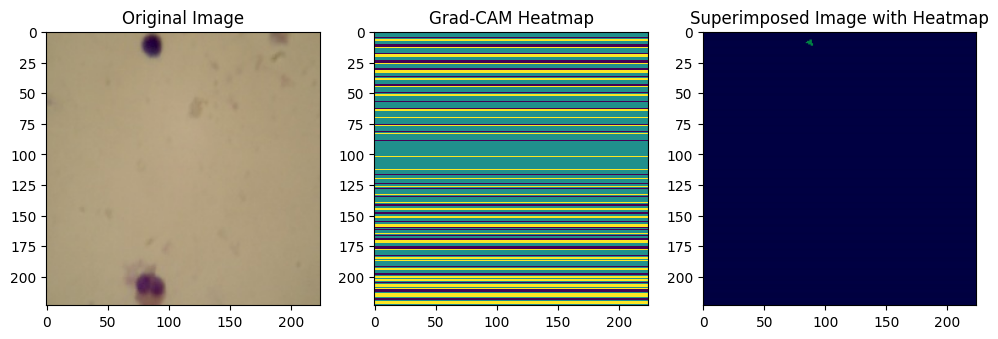

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

mobilenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/mobilenet_branch_model.h5'
mobilenet_model = load_model(mobilenet_model_path)

dir_path = '/content/drive/MyDrive/Resized_Annotated_Folder/With_Bounding_Boxes'
files = os.listdir(dir_path)

# Process the first five images
for i, file in enumerate(files[:5]):
    img_path = os.path.join(dir_path, file)

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    last_conv_layer = mobilenet_model.get_layer('dense_1')

    grad_model = tf.keras.models.Model([mobilenet_model.inputs], [last_conv_layer.output, mobilenet_model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, np.argmax(predictions[0])]

    # ... (previous code)

    grads = tape.gradient(loss, conv_outputs)[0]

    weights = tf.reduce_mean(grads)

    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)

    # Normalize the Grad-CAM values
    cam = cam / cam.max()

    # Adjust the saturation of the heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # ... (remaining code)

    original_img_uint8 = np.uint8(x[0])
    heatmap_uint8 = np.uint8(heatmap)
    superimposed_img = cv2.addWeighted(original_img_uint8, 0.5, heatmap_uint8, 0.5, 0)

    # Display the images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='viridis')
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Superimposed Image with Heatmap')

    plt.show()  # Display the visualization


#DENSE NET

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def create_densenet_branch(input_shape=(224, 224, 3), save_path='densenet_branch_model.h5'):
    densenet_model = DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the pre-trained layers
    for layer in densenet_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(densenet_model)
    model.add(GlobalAveragePooling2D())

    # Add a dense layer for classification
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    # Save the model to the specified path
    model.save(save_path)

    return model

# Example usage
densenet_branch_save_path = '/content/drive/MyDrive/Resized_Annotated_Folder/densenet_branch_model.h5'
densenet_branch = create_densenet_branch(save_path=densenet_branch_save_path)

# Display the summary of the DenseNet branch
densenet_branch.summary()


29084464/29084464 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7168833 (27.35 MB)
Trainable params: 131329 (513.00 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [ ]:

densenet_branch_X_train = X_train
densenet_branch_y_train = y_train
densenet_branch_X_val = X_val
densenet_branch_y_val = y_val


densenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/densenet_branch_model.h5'
densenet_model = load_model(densenet_model_path)

# Compile the DenseNet model
densenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the DenseNet model
densenet_model.fit(densenet_branch_X_train, densenet_branch_y_train, validation_data=(densenet_branch_X_val, densenet_branch_y_val), epochs=10, batch_size=32)


Epoch 1/10
8/8 [==============================] - 72s 8s/step - loss: 0.9724 - accuracy: 0.8202 - val_loss: 0.6480 - val_accuracy: 0.8929
Epoch 2/10
8/8 [==============================] - 52s 6s/step - loss: 0.3887 - accuracy: 0.8728 - val_loss: 0.0629 - val_accuracy: 0.9643
Epoch 3/10
8/8 [==============================] - 50s 6s/step - loss: 0.3778 - accuracy: 0.9167 - val_loss: 0.3840 - val_accuracy: 0.9107
Epoch 4/10
8/8 [==============================] - 62s 8s/step - loss: 0.1358 - accuracy: 0.9518 - val_loss: 0.0407 - val_accuracy: 0.9643
Epoch 5/10
8/8 [==============================] - 53s 6s/step - loss: 0.1363 - accuracy: 0.9561 - val_loss: 0.0943 - val_accuracy: 0.9643
Epoch 6/10
8/8 [==============================] - 50s 6s/step - loss: 0.1047 - accuracy: 0.9474 - val_loss: 0.0296 - val_accuracy: 0.9821
Epoch 7/10
8/8 [==============================] - 50s 6s/step - loss: 0.1303 - accuracy: 0.9518 - val_loss: 0.0434 - val_accuracy: 0.9821
Epoch 8/10
8/8 [==================

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming you've already loaded your datasets (mobilenet_branch_X_val, mobilenet_branch_y_val)

# Evaluate the MobileNet model on the validation set
densenet_predictions = densenet_model.predict(densenet_branch_X_val)
densenet_predictions = (densenet_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(densenet_branch_y_val, densenet_predictions)
classification_report_output = classification_report(densenet_branch_y_val, densenet_predictions, target_names=['Class 0', 'Class 1'])

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_output)


2/2 [==============================] - 13s 3s/step
Accuracy: 0.9821
Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.83      0.91         6
     Class 1       0.98      1.00      0.99        50

    accuracy                           0.98        56
   macro avg       0.99      0.92      0.95        56
weighted avg       0.98      0.98      0.98        56



2/2 [==============================] - 9s 3s/step


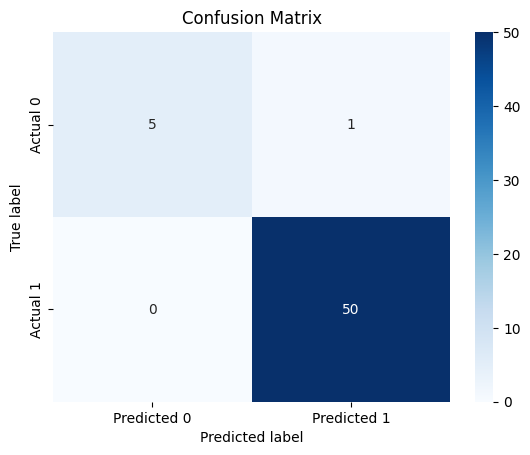

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


densenet_predictions = densenet_model.predict(densenet_branch_X_val)
densenet_predictions = (densenet_predictions > 0.5).astype(int)
conf_matrix = confusion_matrix(densenet_branch_y_val, densenet_predictions)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

mobilenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/densenet_branch_model.h5'
mobilenet_model = load_model(mobilenet_model_path)

mobilenet_model.summary()

last_layer_name = mobilenet_model.layers[-1].name
print("Last Layer Name:", last_layer_name)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7168833 (27.35 MB)
Trainable params: 131329 (513.00 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________
Last Layer Name: dense_3


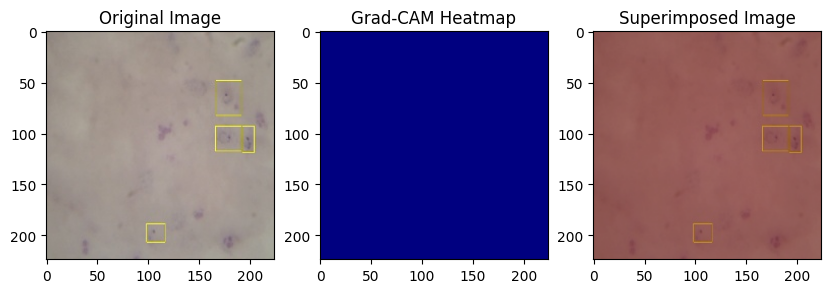

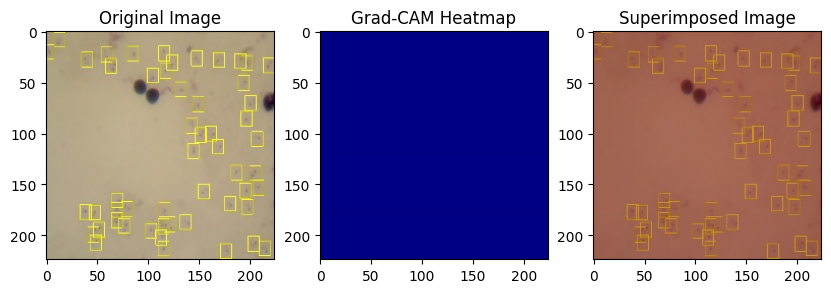

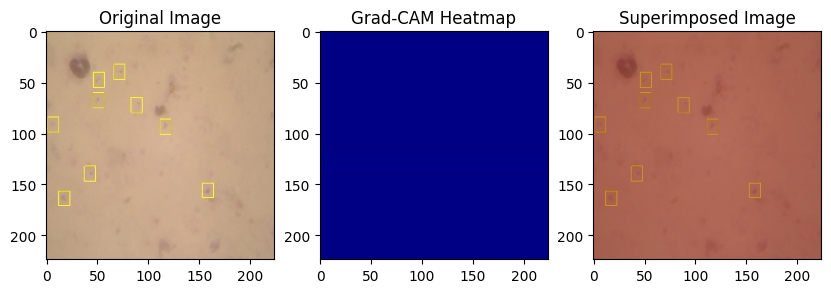

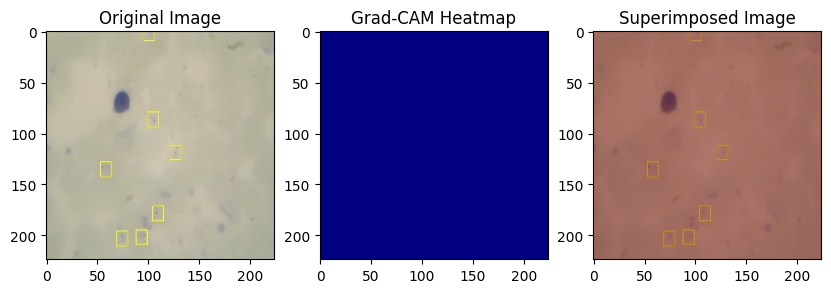

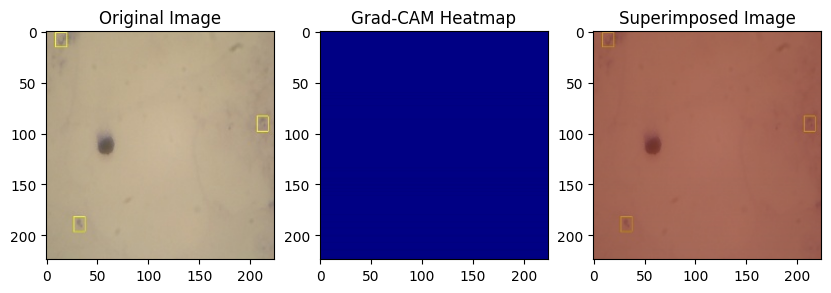

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

densenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/densenet_branch_model.h5'
densenet_model = load_model(densenet_model_path)

def generate_gradcam(img_path, model, layer_name='dense_3'):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    last_conv_layer = model.get_layer(layer_name)

    grad_model = Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]

    guided_grads = (grads * tf.cast(conv_outputs > 0, 'float32'))

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

dir_path = '/content/drive/MyDrive/Resized_Annotated_Folder/With_Bounding_Boxes'
files = os.listdir(dir_path)[:5]

for file in files:
    img_path = os.path.join(dir_path, file)
    cam = generate_gradcam(img_path, densenet_model)
    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (224, 224))
    heatmap = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img[:, :, ::-1])
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img[:, :, ::-1])
    plt.title('Superimposed Image')

    plt.show()


# Inception -V3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def create_inceptionv3_branch(input_shape=(224, 224, 3), save_path='inceptionv3_branch_model.h5'):
    inceptionv3_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    for layer in inceptionv3_model.layers:
        layer.trainable = False
    model = Sequential()
    model.add(inceptionv3_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.save(save_path)

    return model

# Example usage
inceptionv3_branch_save_path = '/content/drive/MyDrive/Resized_Annotated_Folder/inceptionv3_branch_model.h5'
inceptionv3_branch = create_inceptionv3_branch(save_path=inceptionv3_branch_save_path)
inceptionv3_branch.summary()


87910968/87910968 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22065185 (84.17 MB)
Trainable params: 262401 (1.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:

inceptionv3_branch_X_train = X_train
inceptionv3_branch_y_train = y_train
inceptionv3_branch_X_val = X_val
inceptionv3_branch_y_val = y_val

inceptionv3_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/inceptionv3_branch_model.h5'
inceptionv3_model = load_model(inceptionv3_model_path)
inceptionv3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
inceptionv3_model.fit(inceptionv3_branch_X_train, inceptionv3_branch_y_train, validation_data=(inceptionv3_branch_X_val, inceptionv3_branch_y_val), epochs=10, batch_size=32)


Epoch 1/10
8/8 [==============================] - 48s 5s/step - loss: 17.9772 - accuracy: 0.7018 - val_loss: 16.1841 - val_accuracy: 0.8929
Epoch 2/10
8/8 [==============================] - 35s 4s/step - loss: 13.9292 - accuracy: 0.8947 - val_loss: 9.3439 - val_accuracy: 0.8929
Epoch 3/10
8/8 [==============================] - 36s 5s/step - loss: 5.4646 - accuracy: 0.8947 - val_loss: 1.1937 - val_accuracy: 0.8929
Epoch 4/10
8/8 [==============================] - 35s 4s/step - loss: 1.7060 - accuracy: 0.7588 - val_loss: 1.1454 - val_accuracy: 0.8929
Epoch 5/10
8/8 [==============================] - 37s 5s/step - loss: 1.5672 - accuracy: 0.8947 - val_loss: 0.8525 - val_accuracy: 0.9286
Epoch 6/10
8/8 [==============================] - 35s 4s/step - loss: 1.4859 - accuracy: 0.7939 - val_loss: 1.0590 - val_accuracy: 0.9107
Epoch 7/10
8/8 [==============================] - 39s 5s/step - loss: 1.1314 - accuracy: 0.9079 - val_loss: 0.7470 - val_accuracy: 0.9286
Epoch 8/10
8/8 [===============

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

inception_predictions = inceptionv3_model.predict(inceptionv3_branch_X_val)
inception_predictions = (inception_predictions > 0.5).astype(int)
# Calculate metrics
accuracy = accuracy_score(inceptionv3_branch_y_val, inception_predictions)
classification_report_output = classification_report(inceptionv3_branch_y_val, inception_predictions, target_names=['Class 0', 'Class 1'])

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_output)


2/2 [==============================] - 8s 4s/step
Accuracy: 0.9464
Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.50      0.67         6
     Class 1       0.94      1.00      0.97        50

    accuracy                           0.95        56
   macro avg       0.97      0.75      0.82        56
weighted avg       0.95      0.95      0.94        56



2/2 [==============================] - 6s 2s/step


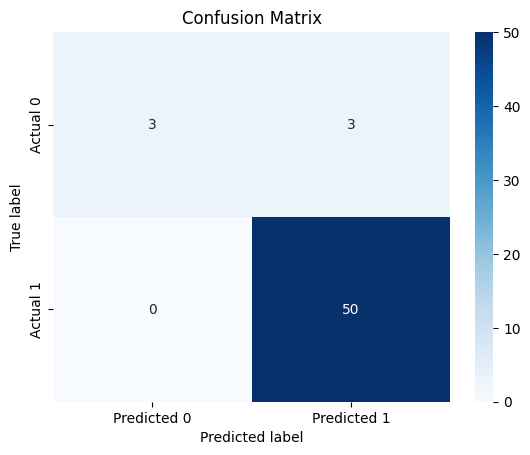

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


inception_predictions = inceptionv3_model.predict(inceptionv3_branch_X_val)
inception_predictions = (inception_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate the confusion matrix
conf_matrix = confusion_matrix(inceptionv3_branch_y_val, inception_predictions)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

inception_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/inceptionv3_branch_model.h5'
inception_model = load_model(inception_model_path)

inception_model.summary()

last_layer_name = inception_model.layers[-1].name
print("Last Layer Name:", last_layer_name)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22065185 (84.17 MB)
Trainable params: 262401 (1.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Last Layer Name: dense_5


<ipython-input-7-e54a80decdb4>:38: RuntimeWarning: invalid value encountered in divide
  cam = cam / cam.max()


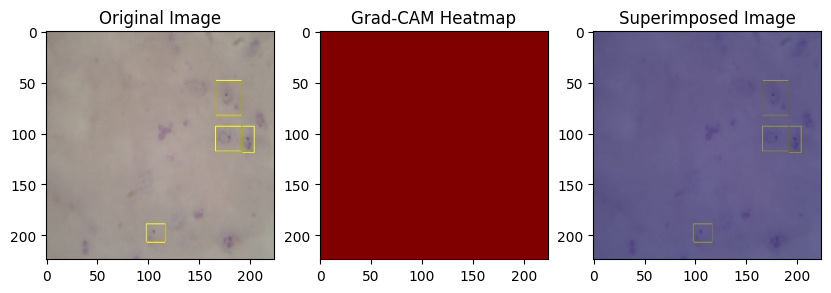

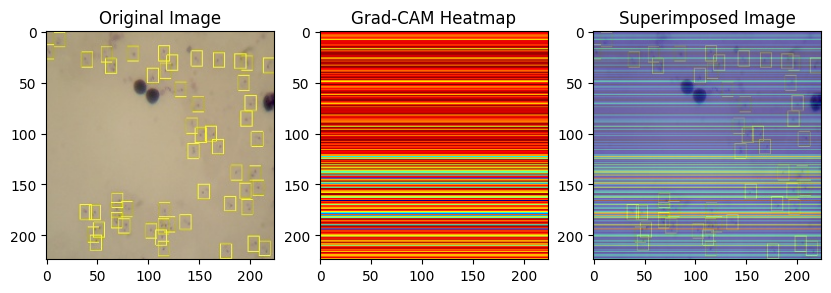

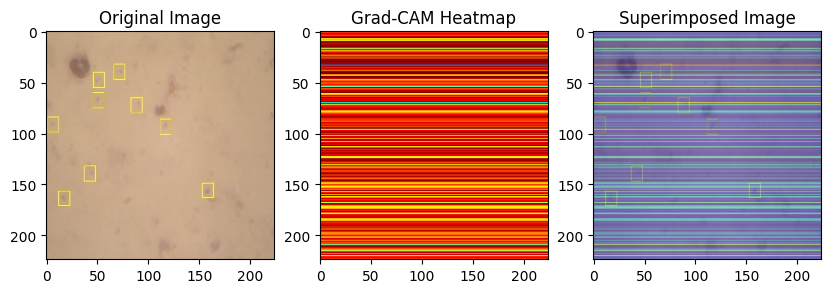

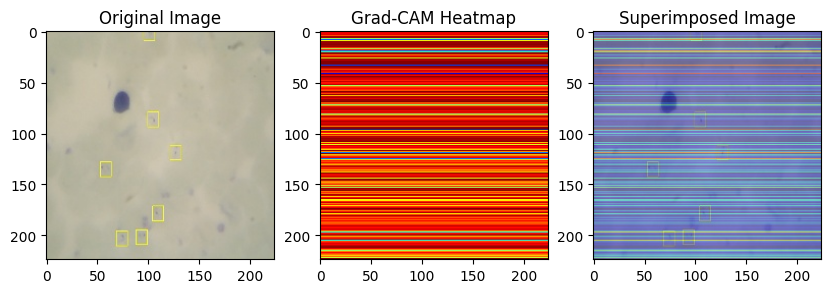

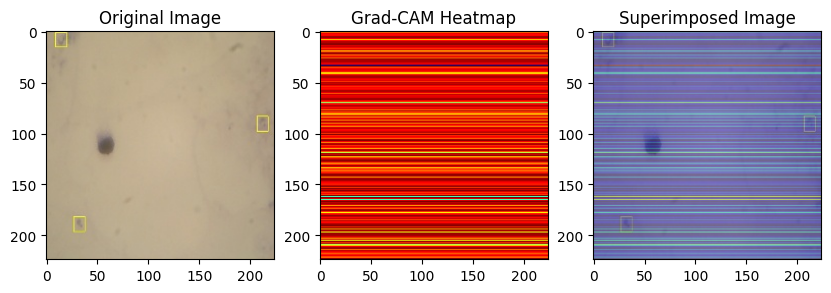

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Load Inception-v3 model
inception_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/inceptionv3_branch_model.h5'
inception_model = load_model(inception_model_path)

# Ensure the model is compiled
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

def generate_gradcam(img_path, model, layer_name='global_average_pooling2d_2'):
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust target size to match the model's expected input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    last_conv_layer = model.get_layer(layer_name)
    model = Model(model.inputs, [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    guided_grads = (grads * tf.cast(conv_outputs > 0, 'float32'))

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

dir_path = '/content/drive/MyDrive/Resized_Annotated_Folder/With_Bounding_Boxes'
files = os.listdir(dir_path)[:5]

for file in files:
    img_path = os.path.join(dir_path, file)
    cam = generate_gradcam(img_path, inception_model)
    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (224, 224))  # Adjust size to match the model's expected input size
    heatmap = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img[:, :, ::-1])
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img[:, :, ::-1])
    plt.title('Superimposed Image')

    plt.show()


# UNET Architecture


In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization

def simple_unet_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom of the U
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder with skip connections
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Create the simplified U-Net model
simple_model = simple_unet_model(input_shape=(224, 224, 3))

# Print the model summary
simple_model.summary()

# Save the model
simple_model.save('/content/drive/MyDrive/Resized_Annotated_Folder/simple_unet_model.h5')


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_66 (Conv2D)          (None, 224, 224, 64)         1792      ['input_7[0][0]']             
                                                                                                  
 conv2d_67 (Conv2D)          (None, 224, 224, 64)         36928     ['conv2d_66[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 64)         0         ['conv2d_67[0][0]']           
 ng2D)                                                                                      